In [2]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Principle Component Analysis

We can do principle component analysis to reduce the dimensionality across the repair outcomes to help identify the repair outcomes which result in the best seperation of the repair outcome profiles

In [3]:
import sqlite3
from src.config import get_db_file, get_hussmann_supplementary_xlsx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
con = sqlite3.connect(get_db_file())
df = pd.read_sql_query('select Barcode, Gene, Alias, outcome, fraction_per_barcode from outcomes where Alias is "MB01"', con)
df_idx = df.set_index(["Alias", "Gene", "Barcode", "outcome"])
df_idx.head(10)

fraction_per_barcode
Alias Gene          Barcode         outcome                                   
MB01  0610009B22Rik 0610009B22Rik-1 DELETION|-10|0||0bp               0.001243
                                    DELETION|-10|19||1bp              0.000355
                                    DELETION|-10|2||1bp               0.004085
                                    DELETION|-10|4||1bp               0.002309
                                    DELETION|-10|5||3bp               0.007105
                                    DELETION|-10|6||2bp               0.002131
                                    DELETION|-11|17||0bp              0.003197
                                    DELETION|-11|2||3bp               0.004796
                                    DELETION|-12|6||0bp               0.001243
                                    DELETION|-13|17||3bp              0.001599

In [5]:
num_genes = df_idx.index.get_level_values("Gene").unique().shape[0]
num_barcodes = df_idx.index.get_level_values("Barcode").unique().shape[0]
num_outcomes = df_idx.index.get_level_values("outcome").unique().shape[0]

print("We have {} unique barcodes covering {} genes, producing {} outcomes".format(num_barcodes, num_genes, num_outcomes))

We have 86569 unique barcodes covering 18363 genes, producing 514242 outcomes


Let's check the barcodes to see if everything from the database sums to one

In [6]:
summed_barcodes = df_idx.groupby(["Alias", "Gene", "Barcode"]).sum() 
(summed_barcodes["fraction_per_barcode"].round(15) != 1.0).any()

False

Possibly some rounding errors happening here, seems like all the barcodes sum up to one. Next, we will take the profiles and aggregate the repair outcomes per sgRNA to repair outcomes per gene. We average the percentages so that outlying sgRNAs do not dominate the entire profile, and then we renormalise the new "average" profile.

Questions:
 - Is this the best way to create an average profile? Perhaps we should look at sgRNAs where one has a very different profile to the others and decide to exclude them instead? A bad sgRNA could still obfuscate some of our results

In [8]:
df_idx_norm_mean = df_idx.groupby(level=["Alias", "Gene", "outcome"]).mean()
totals = df_idx_norm_mean[["fraction_per_barcode"]].sum(level="Gene")
df_idx_norm_mean = df_idx_norm_mean[["fraction_per_barcode"]].div(totals, level="Gene").droplevel(level="Alias")
df_idx_norm_mean.head(10)

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_62549/1514251274.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx_norm_mean[["fraction_per_barcode"]].sum(level="Gene")


fraction_per_barcode
Gene          outcome                                   
0610009B22Rik DELETION|-10|-1||3bp              0.000590
              DELETION|-10|0||0bp               0.001297
              DELETION|-10|14||0bp              0.000697
              DELETION|-10|16||0bp              0.000688
              DELETION|-10|18||0bp              0.000531
              DELETION|-10|19||1bp              0.000677
              DELETION|-10|2||1bp               0.002566
              DELETION|-10|34||1bp              0.001394
              DELETION|-10|4||1bp               0.001795
              DELETION|-10|5||3bp               0.004214

At this point, we have over a half million outcomes (514,242 outcomes). This is too many outcomes for PCA for now. We will limit this to outcomes occuring over a baseline frequency of 0.002 as in Hussmann et al 2021 for now. 

Questions:
 - Is there a better way to decide this frequency? Maybe using an elbow method?
 - Is there a better way to categorise the data? Some of the insertions are definitely too infrequent on their own and are excluded at this point but it is a waste of data. Aggregating this data in some way may be better than what we do currently.  
 

In [9]:
BASELINE_FREQUENCY = 0.002
frequent_outcomes = (df_idx_norm_mean.groupby("outcome").sum().div(num_genes)) > BASELINE_FREQUENCY
frequent_outcomes = frequent_outcomes[frequent_outcomes["fraction_per_barcode"]]
frequent_outcomes = frequent_outcomes.index
frequent_outcomes

Index(['DELETION|-10|2||1bp', 'DELETION|-10|5||3bp', 'DELETION|-10|6||2bp',
       'DELETION|-11|2||3bp', 'DELETION|-14|8||2bp', 'DELETION|-1|5||3bp',
       'DELETION|-1|6||2bp', 'DELETION|-2|2||2bp', 'DELETION|-3|0||1bp',
       'DELETION|-4|7||4bp', 'DELETION|-6|6||2bp', 'DELETION|-8|8||1bp',
       'DELETION|0|1||1bp', 'DELETION|0|3||2bp', 'DELETION|0|6||0bp',
       'HDR|-34|1|ATTAAGGTACC|-1bp', 'INSERTION|0|0|G|-1bp',
       'INSERTION|1|1|A|-1bp', 'WT|0|0||-1bp'],
      dtype='object', name='outcome')

In [10]:
frequent_outcomes.shape

(19,)

In [11]:
df_idx_norm_mean_reduced = df_idx_norm_mean.loc[df_idx_norm_mean.index.get_level_values("outcome").isin(frequent_outcomes)]
totals = df_idx_norm_mean_reduced[["fraction_per_barcode"]].sum(level="Gene")
df_idx_norm_mean_reduced = df_idx_norm_mean_reduced[["fraction_per_barcode"]].div(totals, level="Gene")
df_idx_norm_mean_reduced.head(10)

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_62549/2345324341.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx_norm_mean_reduced[["fraction_per_barcode"]].sum(level="Gene")


fraction_per_barcode
Gene          outcome                                  
0610009B22Rik DELETION|-10|2||1bp              0.003722
              DELETION|-10|5||3bp              0.006112
              DELETION|-10|6||2bp              0.002530
              DELETION|-11|2||3bp              0.010069
              DELETION|-14|8||2bp              0.002066
              DELETION|-1|5||3bp               0.032828
              DELETION|-1|6||2bp               0.007122
              DELETION|-2|2||2bp               0.008153
              DELETION|-3|0||1bp               0.002478
              DELETION|-4|7||4bp               0.056929

In [12]:
avg_repair_outcome_profiles = df_idx_norm_mean_reduced.reset_index().pivot(index=["Gene"], columns="outcome", values="fraction_per_barcode").fillna(0)
avg_repair_outcome_profiles.head()

outcome,DELETION|-10|2||1bp,DELETION|-10|5||3bp,DELETION|-10|6||2bp,DELETION|-11|2||3bp,DELETION|-14|8||2bp,DELETION|-1|5||3bp,DELETION|-1|6||2bp,DELETION|-2|2||2bp,DELETION|-3|0||1bp,DELETION|-4|7||4bp,DELETION|-6|6||2bp,DELETION|-8|8||1bp,DELETION|0|1||1bp,DELETION|0|3||2bp,DELETION|0|6||0bp,HDR|-34|1|ATTAAGGTACC|-1bp,INSERTION|0|0|G|-1bp,INSERTION|1|1|A|-1bp,WT|0|0||-1bp
Gene,,,,,,,,,,,,,,,,,,,
0610009B22Rik,0.003722,0.006112,0.002530,0.010069,0.002066,0.032828,0.007122,0.008153,0.002478,0.056929,0.003369,0.001531,0.031107,0.041981,0.012729,0.089516,0.003151,0.031182,0.653424
0610010K14Rik,0.004118,0.004862,0.004695,0.008547,0.004270,0.027283,0.004935,0.009680,0.005792,0.054693,0.004656,0.003092,0.026442,0.041551,0.013150,0.078829,0.003764,0.025544,0.674099
0610030E20Rik,0.004339,0.003264,0.002262,0.010058,0.003962,0.026856,0.004024,0.011634,0.004067,0.066626,0.002932,0.002103,0.027712,0.038158,0.022997,0.062727,0.003275,0.027181,0.675824
0610040J01Rik,0.005970,0.005171,0.003012,0.006494,0.003070,0.019995,0.002097,0.014367,0.004111,0.055623,0.003982,0.003539,0.021966,0.051466,0.009463,0.061756,0.004068,0.026826,0.697023
1110004F10Rik,0.002679,0.006331,0.006702,0.008369,0.003282,0.025491,0.007158,0.011225,0.006076,0.066460,0.003054,0.002432,0.024508,0.043730,0.016347,0.101437,0.001497,0.033600,0.629622


In [13]:
avg_repair_outcome_profiles.shape

(18363, 19)

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = avg_repair_outcome_profiles
X.head()

outcome,DELETION|-10|2||1bp,DELETION|-10|5||3bp,DELETION|-10|6||2bp,DELETION|-11|2||3bp,DELETION|-14|8||2bp,DELETION|-1|5||3bp,DELETION|-1|6||2bp,DELETION|-2|2||2bp,DELETION|-3|0||1bp,DELETION|-4|7||4bp,DELETION|-6|6||2bp,DELETION|-8|8||1bp,DELETION|0|1||1bp,DELETION|0|3||2bp,DELETION|0|6||0bp,HDR|-34|1|ATTAAGGTACC|-1bp,INSERTION|0|0|G|-1bp,INSERTION|1|1|A|-1bp,WT|0|0||-1bp
Gene,,,,,,,,,,,,,,,,,,,
0610009B22Rik,0.003722,0.006112,0.002530,0.010069,0.002066,0.032828,0.007122,0.008153,0.002478,0.056929,0.003369,0.001531,0.031107,0.041981,0.012729,0.089516,0.003151,0.031182,0.653424
0610010K14Rik,0.004118,0.004862,0.004695,0.008547,0.004270,0.027283,0.004935,0.009680,0.005792,0.054693,0.004656,0.003092,0.026442,0.041551,0.013150,0.078829,0.003764,0.025544,0.674099
0610030E20Rik,0.004339,0.003264,0.002262,0.010058,0.003962,0.026856,0.004024,0.011634,0.004067,0.066626,0.002932,0.002103,0.027712,0.038158,0.022997,0.062727,0.003275,0.027181,0.675824
0610040J01Rik,0.005970,0.005171,0.003012,0.006494,0.003070,0.019995,0.002097,0.014367,0.004111,0.055623,0.003982,0.003539,0.021966,0.051466,0.009463,0.061756,0.004068,0.026826,0.697023
1110004F10Rik,0.002679,0.006331,0.006702,0.008369,0.003282,0.025491,0.007158,0.011225,0.006076,0.066460,0.003054,0.002432,0.024508,0.043730,0.016347,0.101437,0.001497,0.033600,0.629622


In [15]:
sparseness = (X == 0).sum().sum() / (X.shape[0] * X.shape[1])
print("The matrix is {:.3f} sparse. Could this be a problem for PCA?".format(sparseness))

The matrix is 0.008 sparse. Could this be a problem for PCA?


It seems there may be an issue here with sparseness. I have two options. Choose a version of PCA which can handle sparse data, or remove the "sparser" columns through some sort of filtering.


I don't want to throw out data. Might be a question for Joana at this point.

Question:
 - How should we handle the sparse data when looking at PCA? Current (as above) I filter out very rare outcomes (< 0.002)

For now, we will remove rarer measurements. We copy Hussmann et. al 2021 for now, and filter out any repair outcomes with a frequency less than 0.0002 (or 0.2%). Note that in the Hussmann paper, it is not clear what this "baseline" is. We take it to be the average frequency of the outcome across all gene-wise repair outcome profiles. 

First, we standardise the data to give it zero mean and unit variance.

In [16]:
# standardise the data
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
X_st = pd.DataFrame(X_st, index=X.index, columns=X.columns)
X_st.head()

outcome,DELETION|-10|2||1bp,DELETION|-10|5||3bp,DELETION|-10|6||2bp,DELETION|-11|2||3bp,DELETION|-14|8||2bp,DELETION|-1|5||3bp,DELETION|-1|6||2bp,DELETION|-2|2||2bp,DELETION|-3|0||1bp,DELETION|-4|7||4bp,DELETION|-6|6||2bp,DELETION|-8|8||1bp,DELETION|0|1||1bp,DELETION|0|3||2bp,DELETION|0|6||0bp,HDR|-34|1|ATTAAGGTACC|-1bp,INSERTION|0|0|G|-1bp,INSERTION|1|1|A|-1bp,WT|0|0||-1bp
Gene,,,,,,,,,,,,,,,,,,,
0610009B22Rik,-0.303243,0.373901,-0.674603,0.484776,-0.473424,1.263417,0.860678,-0.869527,-1.119355,0.211319,-0.285763,-0.717544,0.598345,0.298870,-0.333502,0.698481,-0.369355,0.554147,-0.469755
0610010K14Rik,-0.126390,-0.182699,0.328952,-0.036704,0.663806,0.331989,-0.113010,-0.412154,0.418520,0.008799,0.328411,0.055813,-0.214061,0.245874,-0.226855,0.090081,-0.054553,-0.487007,-0.042405
0610030E20Rik,-0.027821,-0.894339,-0.799129,0.480937,0.505093,0.260188,-0.518512,0.172935,-0.381945,1.089714,-0.494835,-0.434017,0.007184,-0.172351,2.269718,-0.826523,-0.305724,-0.184634,-0.006740
0610040J01Rik,0.700590,-0.044789,-0.451454,-0.739905,0.044693,-0.892336,-1.376681,0.991766,-0.361510,0.092998,0.006829,0.277330,-0.993439,1.467718,-1.161520,-0.881796,0.101955,-0.250331,0.431465
1110004F10Rik,-0.768572,0.471747,1.259381,-0.097661,0.153902,0.030850,0.876935,0.050401,0.550298,1.074690,-0.436315,-0.271096,-0.550675,0.514335,0.583810,1.377128,-1.219703,1.000796,-0.961772


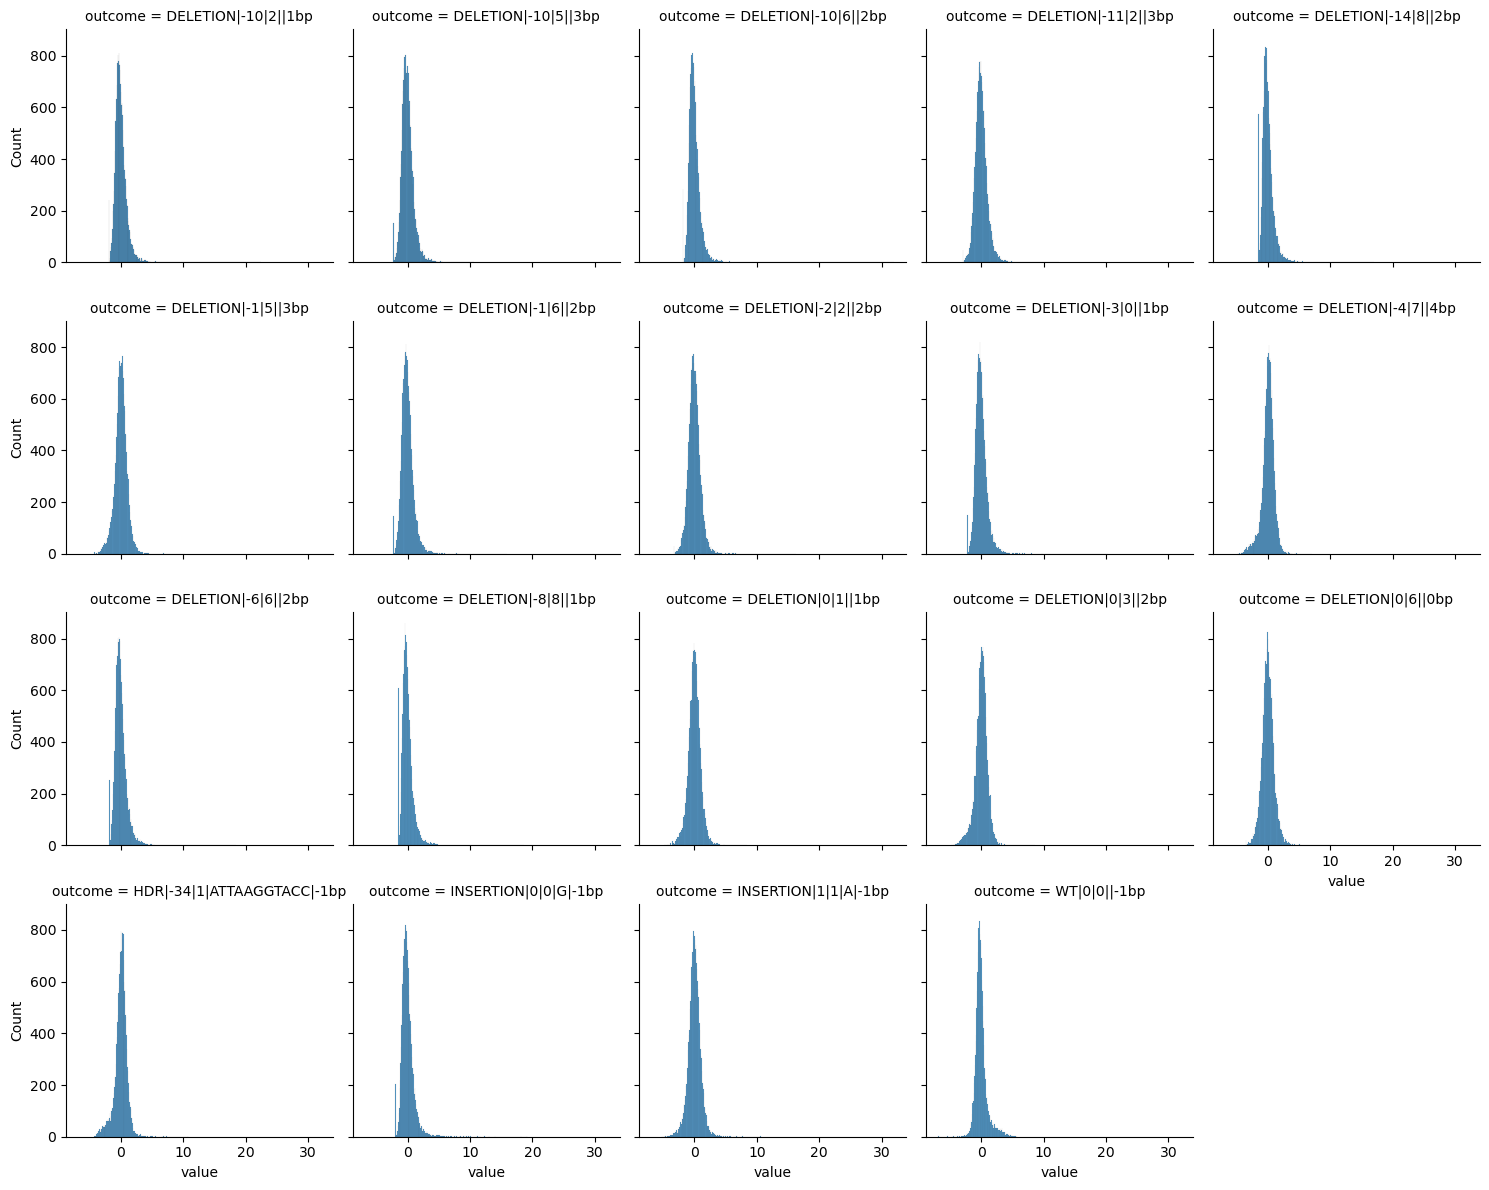

In [17]:
g = sns.FacetGrid(X_st.melt(), col="outcome", col_wrap=5)
g.map(sns.histplot, "value")

In [18]:
# fit the PCA model
pca_out = PCA().fit(X_st)

# get the component variance
print("Component variance")
print(pca_out.explained_variance_ratio_)

# Cumulative proportion of variance 
print("Cumulative proportion of variance explained")
cum_variance = np.cumsum(pca_out.explained_variance_ratio_)
print(np.cumsum(pca_out.explained_variance_ratio_))

Component variance
[2.64741690e-01 7.34391254e-02 5.09116300e-02 4.95139847e-02
 4.89523690e-02 4.84041526e-02 4.82053935e-02 4.72169172e-02
 4.71434825e-02 4.59119166e-02 4.46737807e-02 4.23161735e-02
 4.00946241e-02 3.71889437e-02 3.50534880e-02 2.94799822e-02
 2.54102442e-02 2.13421022e-02 7.12544642e-32]
Cumulative proportion of variance explained
[0.26474169 0.33818082 0.38909245 0.43860643 0.4875588  0.53596295
 0.58416835 0.63138526 0.67852874 0.72444066 0.76911444 0.81143062
 0.85152524 0.88871418 0.92376767 0.95324765 0.9786579  1.
 1.        ]


In [19]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i)+"\n{:.3f}".format(cum_variance[i-1]) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X_st.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1\n0.265,PC2\n0.338,PC3\n0.389,PC4\n0.439,PC5\n0.488,PC6\n0.536,PC7\n0.584,PC8\n0.631,PC9\n0.679,PC10\n0.724,PC11\n0.769,PC12\n0.811,PC13\n0.852,PC14\n0.889,PC15\n0.924,PC16\n0.953,PC17\n0.979,PC18\n1.000,PC19\n1.000
variable,,,,,,,,,,,,,,,,,,,
DELETION|-10|2||1bp,0.112436,0.311464,-0.082665,0.108799,0.008047,0.350262,0.431465,0.685931,0.066432,-0.280033,-0.020945,-0.004078,0.028885,0.074567,0.004560,0.026390,-0.013366,0.004613,0.040827
DELETION|-10|5||3bp,0.129429,0.276939,-0.232482,-0.087090,-0.280078,0.248027,-0.416239,-0.235878,0.321732,-0.479920,0.344888,-0.123125,-0.030727,-0.062833,-0.005962,0.038560,-0.005482,0.001947,0.040929
DELETION|-10|6||2bp,0.078876,0.344009,0.323763,-0.324006,0.659875,-0.004600,-0.103124,-0.136409,-0.226930,-0.340719,-0.094411,0.089918,0.072743,-0.085387,0.034006,0.023135,-0.023043,0.000545,0.039315
DELETION|-11|2||3bp,0.185292,0.088344,0.191387,-0.050368,0.253620,-0.030316,0.029958,0.129949,0.071336,0.413819,0.703786,-0.356534,-0.160917,0.077650,0.043906,0.007850,-0.012357,0.002385,0.053210
DELETION|-14|8||2bp,0.068987,0.318562,0.574097,-0.235134,-0.539772,-0.210929,-0.229109,0.253396,-0.062248,0.099216,-0.177509,-0.052846,-0.071689,-0.017393,-0.015538,-0.029187,-0.012666,-0.019356,0.035317
DELETION|-1|5||3bp,0.299963,-0.133721,-0.000817,-0.006816,-0.028133,-0.055639,0.033563,0.027862,-0.023866,0.034365,-0.022828,-0.015319,0.119625,-0.325087,-0.342288,0.766180,-0.200650,0.087065,0.108500
DELETION|-1|6||2bp,0.132913,0.275516,-0.281295,-0.064727,0.242721,0.194018,-0.354694,0.115395,0.370475,0.504974,-0.425498,0.019929,-0.092177,-0.051244,-0.008249,-0.016066,-0.010866,0.022146,0.040933
DELETION|-2|2||2bp,0.214531,-0.007312,-0.019053,-0.095636,-0.062996,0.014199,-0.063849,0.061695,-0.015047,0.119270,0.300125,0.890635,-0.063610,0.136922,0.084152,0.031124,-0.002816,-0.006964,0.060849
DELETION|-3|0||1bp,0.117744,0.245051,0.367407,0.396186,0.008266,-0.075356,0.391144,-0.407633,0.534895,0.012045,-0.085538,0.115842,0.002332,-0.003135,0.003244,0.008672,0.023557,0.006049,0.039279


In [20]:
pca_scores = pca_out.transform(X_st)
pca_scores_df = pd.DataFrame(pca_scores, columns=pc_list, index=X_st.index)
pca_scores_df.head()

,PC1\n0.265,PC2\n0.338,PC3\n0.389,PC4\n0.439,PC5\n0.488,PC6\n0.536,PC7\n0.584,PC8\n0.631,PC9\n0.679,PC10\n0.724,PC11\n0.769,PC12\n0.811,PC13\n0.852,PC14\n0.889,PC15\n0.924,PC16\n0.953,PC17\n0.979,PC18\n1.000,PC19\n1.000
Gene,,,,,,,,,,,,,,,,,,,
0610009B22Rik,0.931743,-1.292284,-0.725087,-0.024570,0.170071,0.527011,-0.951552,0.410205,0.111731,0.324008,-0.188506,-1.243260,-0.721290,-0.585696,-0.424620,0.698019,-0.067501,0.405999,3.247800e-16
0610010K14Rik,0.002520,0.418827,0.698152,-0.081183,-0.197826,-0.111331,0.214675,-0.228835,-0.162523,0.131237,-0.250032,-0.224757,0.152943,-0.651066,-0.352322,-0.046153,-0.174011,0.080738,1.058556e-15
0610030E20Rik,0.392869,-1.175186,0.689712,-0.126470,-0.536491,-0.192488,0.040531,0.764458,-0.026273,0.799953,0.244482,-0.272368,1.801933,0.875505,0.615995,0.401461,0.008312,-1.335686,-1.021999e-15
0610040J01Rik,-0.949643,-0.057185,-0.249852,0.040108,-0.830292,-0.099491,0.797857,0.486731,-0.571600,-0.902108,0.642901,1.283900,-0.361691,0.044145,-0.800134,-1.388457,-1.347285,-0.635949,-1.698835e-16
1110004F10Rik,1.817983,-0.473830,0.802270,-1.161822,0.837416,0.437381,-0.670195,-0.955648,0.835736,-0.284405,-0.820918,-0.035073,0.082018,0.382123,-0.887929,-0.702286,0.685389,0.096934,2.466786e-15


In [21]:
sns.scatterplot(data=pca_scores_df, x=pca_scores_df.columns[0], y=pca_scores_df.columns[1])

<AxesSubplot:xlabel='PC1\n0.265', ylabel='PC2\n0.338'>

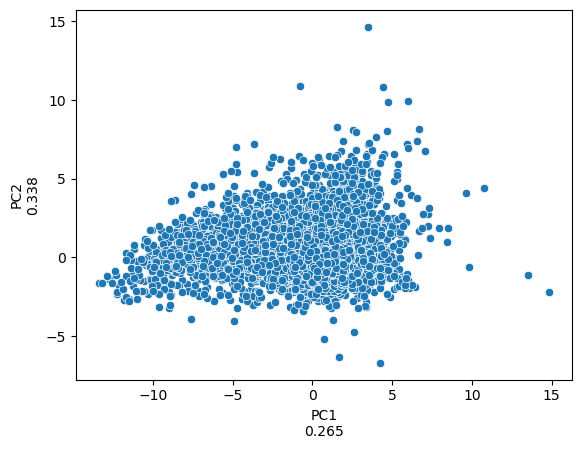

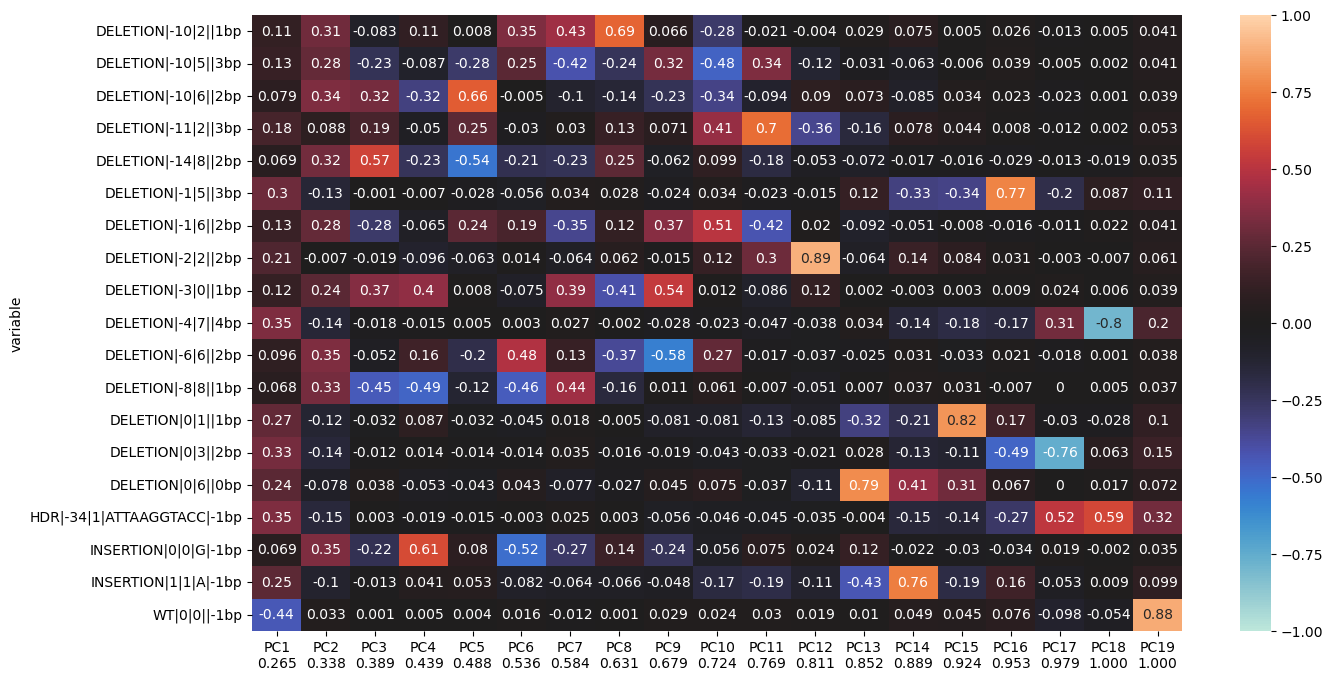

In [22]:
# get correlation matrix plot for loadings
# cmap = sns.diverging_palette(220, 20, as_cmap=True)
plt.figure(figsize=(15,8))
ax = sns.heatmap(loadings_df.round(3), annot=True, center=0, vmin=-1, vmax=1)
plt.show()

Most of the variance in the data among the repair outcome profiles can be explained by their influence on the proportion of WT data seen. Need to review this with Robin and see if this is interesting, or if we need to be filtering out this wild-type data and focusing exclusively on the repair outcome profiles. 

#### Questions
**Q: Could this also cause problems when using correlation as a distance metric?**
 
**Q: Does this say anything about this gene affecting the ability of the cell to repair properly? Or is this simply an artifact to be ignored? Probably caused by natural variation between cellular efficency? Maybe if I annotate known repair genes/most similar and dissimilar I might be able to get an idea.**

**Q: Could I just look at the points nearest the origin for the least variation? These are the points which are closest to the average across all variables.**

A: This would not make sense, as you might aswell just take the average then, rather than cherry pick points that will result in an average anyway.

In [23]:
pca_scores_df.loc[pca_scores_df.iloc[:,0] > 12,:]

,PC1\n0.265,PC2\n0.338,PC3\n0.389,PC4\n0.439,PC5\n0.488,PC6\n0.536,PC7\n0.584,PC8\n0.631,PC9\n0.679,PC10\n0.724,PC11\n0.769,PC12\n0.811,PC13\n0.852,PC14\n0.889,PC15\n0.924,PC16\n0.953,PC17\n0.979,PC18\n1.000,PC19\n1.000
Gene,,,,,,,,,,,,,,,,,,,
Trp53,14.854830,-2.191943,-0.179525,1.151817,0.344725,-0.789714,-0.282146,0.602681,-0.416582,-0.330077,-0.253704,0.569999,-1.708902,-2.207579,1.824419,-1.107242,-0.472980,2.203565,1.986586e-15
Vmn1r128,13.481725,-1.123363,-4.914507,-2.650310,0.632352,2.916743,-3.695982,3.761014,2.062529,4.009162,1.416469,11.265139,-1.095020,1.139213,0.682033,5.631072,3.457951,1.017700,1.781114e-15


In [24]:
X.head()

outcome,DELETION|-10|2||1bp,DELETION|-10|5||3bp,DELETION|-10|6||2bp,DELETION|-11|2||3bp,DELETION|-14|8||2bp,DELETION|-1|5||3bp,DELETION|-1|6||2bp,DELETION|-2|2||2bp,DELETION|-3|0||1bp,DELETION|-4|7||4bp,DELETION|-6|6||2bp,DELETION|-8|8||1bp,DELETION|0|1||1bp,DELETION|0|3||2bp,DELETION|0|6||0bp,HDR|-34|1|ATTAAGGTACC|-1bp,INSERTION|0|0|G|-1bp,INSERTION|1|1|A|-1bp,WT|0|0||-1bp
Gene,,,,,,,,,,,,,,,,,,,
0610009B22Rik,0.003722,0.006112,0.002530,0.010069,0.002066,0.032828,0.007122,0.008153,0.002478,0.056929,0.003369,0.001531,0.031107,0.041981,0.012729,0.089516,0.003151,0.031182,0.653424
0610010K14Rik,0.004118,0.004862,0.004695,0.008547,0.004270,0.027283,0.004935,0.009680,0.005792,0.054693,0.004656,0.003092,0.026442,0.041551,0.013150,0.078829,0.003764,0.025544,0.674099
0610030E20Rik,0.004339,0.003264,0.002262,0.010058,0.003962,0.026856,0.004024,0.011634,0.004067,0.066626,0.002932,0.002103,0.027712,0.038158,0.022997,0.062727,0.003275,0.027181,0.675824
0610040J01Rik,0.005970,0.005171,0.003012,0.006494,0.003070,0.019995,0.002097,0.014367,0.004111,0.055623,0.003982,0.003539,0.021966,0.051466,0.009463,0.061756,0.004068,0.026826,0.697023
1110004F10Rik,0.002679,0.006331,0.006702,0.008369,0.003282,0.025491,0.007158,0.011225,0.006076,0.066460,0.003054,0.002432,0.024508,0.043730,0.016347,0.101437,0.001497,0.033600,0.629622


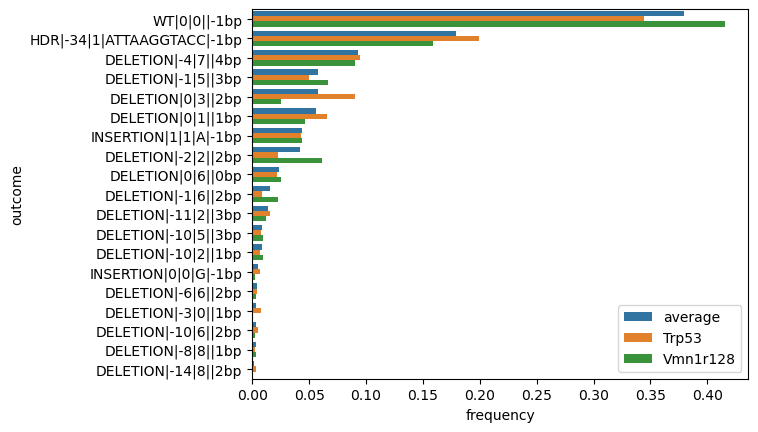

In [28]:
gene_of_interests = ["Trp53", "Vmn1r128"]
average_repair_outcome_profile = X[X.index.isin(gene_of_interests)].mean().sort_values(ascending=False).to_frame(name="frequency")
average_repair_outcome_profile["gene"] = "average"
repair_profile_plot = [average_repair_outcome_profile]
for g in gene_of_interests:
    goi_repair_outcome_profile = X.loc[g].sort_values(ascending=False).to_frame(name="frequency")
    goi_repair_outcome_profile["gene"] = g
    repair_profile_plot.append(goi_repair_outcome_profile)
repair_profile_plot = pd.concat(repair_profile_plot).reset_index()
sns.barplot(data=repair_profile_plot, x="frequency", y="outcome", hue="gene")
plt.legend(loc='lower right')
plt.show()